In [43]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
from scipy.linalg import expm, logm
sys.path.append('../') # Add parent directory to the system path

In [44]:
# This import requires previous directory to be appended to sys.path
from direct_decomposition import direct_decomposition, random_unitary
from numeric_truncated_unitaries import pad_matrix

In [45]:
def a(n):
    """
    Annihilation operator truncated at n photons and padded with zeros until the shape is a power of two.
    (This is so the photon number space of the interferometer can be represented with qubits)
    """
    d = n + 1 # The unpadded creation operator truncated at n photons has dimension dxd
    matrix = np.zeros((d, d))
    for i in range(1, d):
        matrix[i-1, i] = np.sqrt(i)
    matrix = pad_matrix(matrix) # Pad with zeros
    return matrix

def ad(n):
    """
    Creation operator truncated at n photons
    """
    return np.transpose(a(n))

In [46]:
# Test
a(2)

array([[0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.41421356, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [47]:
def op_basis_element(M, N, i, j):
    """
    Get the (i,j)th basis element of an M mode interferometer supporting up to N photons
    Where i is the index of the creation operator and j is the index of the annihilation operator

    Example 1:
    (M = 3, N = 2, i = 1, j = 1)

    $$ I_{(N=2)} \otimes a^\dagger_{(N=2)} a_{(N=2)} \otimes I_{(N=2)} $$

    Example 2:
    (M = 4, N = 4, i = 0, j = 3)

    $$ a^\dagger_{(N=4)} \otimes I_{(N=4)} \otimes I_{(N=4)} \otimes a_{(N=4)} $$
    """

    def get_kronecker_term(idx):
        """
        Find the kth term in the kronecker product of the basis element where k = idx.

        Example:
            Suppose the basis operator has the form
            $$a_{(N)}^\dagger \otimes a_{(N)} $$

            get_kronecker_term(1) would $a_{(N)}^\dagger$.
        """
        if idx == i and idx == j:
            return ad(N) @ a(N)
        elif idx == i:
            return ad(N)
        elif idx == j:
            return a(N)
        else:
            return pad_matrix(np.eye(N+1, N+1)) 
            # Plus one and pad the identity since this implicitly happens in the functions generating
            # creation and annihilation operators.

    assert(i < M and j < M), "Index or indices out of range"
    basis_element = get_kronecker_term(0)
    for k in range(1, M):
        kron_term = get_kronecker_term(k)
        basis_element = np.kron(basis_element, kron_term)
    return basis_element


Test case: $M = 2$, $N = 2$, $i = 0$, $j = 1$
</br>

$a^\dagger_{(N=2)} \otimes a_{N=2} = $

</br>

$
\begin{pmatrix}
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & \sqrt{2} & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
\otimes
\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & \sqrt{2} & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
$

$$
=
\begin{pmatrix}
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

In [48]:
# Comparing test case to mathematica output:
test_element = op_basis_element(2, 2, 0, 1)
print(np.shape(test_element))
print(test_element[4][1], test_element[5][2], test_element[8][5], test_element[9][6])
# Test passed -- Output is matching for all non-zero elements

(16, 16)
1.0 1.4142135623730951 1.4142135623730951 2.0000000000000004


In [49]:
def expanded_unitary(U, N):
    """
    This function takes an MxM unitary U corresponding to the action of an M mode interferometer on the 
    creation operators and returns a unitary in the second quantization picture that can support up
    to N photons per mode.
    """
    M = np.shape(U)[0]
    # Get Hamiltonian from unitary:
    H = -1j * logm(U)
    expanded_H = 0
    # Sum basis elements multiplied by the corresponding Hamiltonian terms
    for i in range(M):
        for j in range(M):
            expanded_H += H[i][j] * op_basis_element(M, N, i, j)
    return expm(1j * expanded_H)

In [50]:
# Test expanded_unitary
r2 = 1/np.sqrt(2)
test_U = np.matrix([[r2, r2, 0],[r2,-r2,0],[0,0,1]])
test_U_1photon = expanded_unitary(test_U, 1) 
print(sum(np.diag(test_U_1photon))) # Checksum
# Expected checksum value = 0 (Verified by Mathematica)

test_U_2photon = expanded_unitary(test_U, 2)
print(sum(np.diag(test_U_2photon))) # Checksum
# Expected checksum value = 46. + 4.7475 i (Verified by Mathematica)

test_U_3photon = expanded_unitary(test_U, 3)
print(sum(np.diag(test_U_3photon))) # Checksum
# Expected checksum value = 5.86996. - 7.45626 i (Verified by Mathematica)

(1.7763568394002505e-15+7.216063182081298e-15j)
(46.000000000000014+4.747500951788335j)
(5.869957263668627-7.456259390505789j)


In [51]:
# Make a random unitary R to simulate
R = random_unitary(3)
U_expd = expanded_unitary(R, 2)
print(R)
print(np.shape(U_expd))

[[-0.41153171+0.36317891j -0.41593966+0.65583134j  0.30826727-0.02436128j]
 [ 0.02696661-0.46559546j  0.26259804+0.04376347j  0.84268951-0.03866643j]
 [-0.26829742-0.63972877j  0.21468321+0.52907239j -0.43763822+0.03507009j]]
(64, 64)


In [52]:
# Initialize statevector

def make_initial_state(qubit_bitstring):
    """
    Given a bitstring representing an initial qubit state, this function finds the corresponding statevector.

    Example:
        qubit_bitstring = [0,1]
        initial state = $|01\rangle$
        return np.matrix[[0],[1],[0],[0]]
    """

    ket_0 = np.matrix([1,0])
    ket_1 = np.matrix([0,1])

    # This can be tidied
    if qubit_bitstring[0] == 0:
        initial_state = ket_0
    elif qubit_bitstring[0] == 1:
        initial_state = ket_1

    for qubit in qubit_bitstring[1::]:
        if qubit == 0:
            initial_state = np.kron(initial_state, ket_0)
        if qubit == 1:
            initial_state = np.kron(initial_state, ket_1)
    
    return np.transpose(initial_state)

qubit_bitstring = [0,1,0,1,0,0]
initial_state = make_initial_state(qubit_bitstring)
final_state = U_expd @ initial_state
expectation_values = np.square(np.abs(final_state)) # Expectation values for observables

In [53]:
def reverse_blocks(string, m):
    """
    This function splits a string up into blocks of length m, reverses the 
    order of the blocks and returns the resulting string
    """
    blocks = [string[i:i+m] for i in range(0, len(string), m)]
    reversed_blocks = blocks[::-1]
    reversed_string = ''.join(reversed_blocks)
    return reversed_string


def format_bitstring(observable, num_qubits = 6, qubits_per_mode = 2, little_endian = True):
    """
    This function takes an observable (integer) and converts it into a bitstring in the qiskit
    convention.

    First, the observable is represented in binary, and padded with zeros on the left hand side
    up to the number of qubits.

    Then, the bitstring is split up into m blocks, where m = qubits_per_mode. The order of the blocks
    is reversed and the resulting string is returned.
    """
    bitstring = bin(observable)[2:]
    bitstring = '0' * (num_qubits - len(bitstring)) + bitstring 
    # Iterate over the bit string in m-step increments and flip substrings
    final_bitstring = reverse_blocks(bitstring, qubits_per_mode)
    return final_bitstring


def format_expectations(expectation_values):
    """
    Convert the expectations into a dictionary compatible with qiskit formatting
    """
    exp_dict = dict()
    for idx, val in enumerate(expectation_values[:]):
        if val != 0.0:
            bitstring = format_bitstring(idx)
            exp_dict[bitstring] = float(val)
    return exp_dict


def pprint_expectations(expectation_values):
    """
    Pretty print the expectation values generated in the previous cell
    """
    for idx, val in enumerate(expectation_values[:]):
        if val != 0.0:
            print(f"idx: {idx},  val: {float(val)}")
            print(format_bitstring(idx))

pprint_expectations(expectation_values)
exp_dict = format_expectations(expectation_values)
    

idx: 2,  val: 0.31377236614206117
100000
idx: 5,  val: 0.11440807326487393
010100
idx: 8,  val: 0.030830640898105548
001000
idx: 17,  val: 0.0652900708716124
010001
idx: 20,  val: 0.11230994983980766
000101
idx: 32,  val: 0.36338889898353977
000010


In [54]:
def run_circuit_simulation(U, initial_state, num_shots, num_photons):
    num_modes = int(np.shape(U)[0])
    qubits_per_mode = int(np.ceil(np.log2(num_photons + 1)))
    num_qubits = qubits_per_mode * num_modes
    circuit = QuantumCircuit(num_qubits)
    
    # # This needs to be tested in greater detail
    # initial_state = ""
    # for i in range(num_modes):
    #     if i > num_modes - (num_photons + 1):
    #         initial_state += "0" * (qubits_per_mode - 1) + "1"
    #     else:
    #         initial_state += "0" * qubits_per_mode
    # initial_state = "000101" #debug
    
    print(f"Initial state: {initial_state}")
    circuit.initialize(initial_state)
    # circuit.initialize("000101")
    interferom = direct_decomposition(R, num_photons)
    circuit.compose(interferom, qubits=list(range(num_qubits)), inplace=True)
    circuit.measure_all()

    simulator = AerSimulator()
    circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots=num_shots).result()
    counts = result.get_counts(circuit)

    # Convert counts to probabilities
    for key in counts.keys():
        counts[key] = counts[key] / num_shots
    return counts


In [55]:
shots_1e3 = run_circuit_simulation(R, "000101", 1e3, num_photons=2)

Initial state: 000101


In [56]:
shots_1e4 = run_circuit_simulation(R, "000101", 1e4, num_photons=2)

Initial state: 000101


In [57]:
shots_1e5 = run_circuit_simulation(R, "000101", 1e5, num_photons=2)

Initial state: 000101


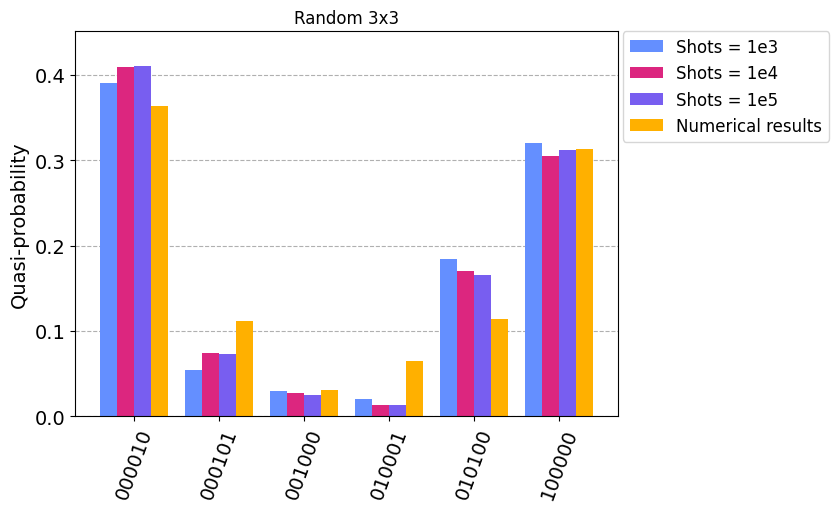

In [58]:
legend = ['Shots = 1e3', 'Shots = 1e4', 'Shots = 1e5', 'Numerical results']
plot_histogram([shots_1e3, shots_1e4, shots_1e5, exp_dict], legend=legend, title='Random 3x3', bar_labels=False)

In [59]:
from boson_sampling_probabilities import output_probability

In [60]:
output_states = [[2,0,0],[0,2,0],[0,0,2],[1,1,0],[1,0,1],[0,1,1]]
for state in output_states:
    print(f"Probability of output {state} = {output_probability([1,1,0], state, R)}")

Probability of output [2, 0, 0] = 0.36338889898353893
Probability of output [0, 2, 0] = 0.03083064089810551
Probability of output [0, 0, 2] = 0.31377236614206105
Probability of output [1, 1, 0] = 0.11230994983980791
Probability of output [1, 0, 1] = 0.06529007087161286
Probability of output [0, 1, 1] = 0.11440807326487364


In [61]:
keys = ["000010","001000","100000","000101","010001","010100"]
for key in keys:
    print(exp_dict[key])

0.36338889898353977
0.030830640898105548
0.31377236614206117
0.11230994983980766
0.0652900708716124
0.11440807326487393


In [62]:
keys = ["000010","001000","100000","000101","010001","010100"]
for key in keys:
    print(shots_1e5[key])

0.41006
0.02553
0.31224
0.07329
0.01356
0.16532
